# Lab 4: Regularization and Cross-Validation


**Read the material and do the following exercises in the notebook**

** For extra points do the following exercise**

\begin{exercise}
Consider the kc_house_data.csv dataset and modify the following notebook to study the effect of regularization in the following pairs a) "Price vs Square Feet" and b) "Price vs Location of the area".

\end{exercise}

## Table of Contents
<ol start="0">
  <li> Learning Goals </li>
  <li> Review of regularized regression </li>
  <li> Ridge regression with one predictor on a grid </li>
  <li> Ridge regression with polynomial features on a grid</li>
  <li> Cross-validation --- Multiple Estimates </li>
  <li> Cross-validation --- Finding the best regularization parameter </li>
</ol>

## Learning Goals
In this lab, you will work with some noisy data.  You will use  simple linear and ridge regressions to fit linear, high-order polynomial features to the dataset.  You will attempt to figure out what degree polynomial fits the dataset the best and ultimately use cross validation to determine the best polynomial order.  Finally, you will automate the cross validation process using `sklearn` in order to determine the best regularization paramter for the ridge regression analysis on your dataset.

By the end of this lab, you should:
* Really understand regularized regression principles.
* Have a good grasp of working with ridge regression through the `sklearn` API
* Understand the effects of the regularization (a.k.a penalization) parameter on fits from ridge regression
* Understand the ideas behind cross-validation
  * Why is it necessary?
  * Why is it important?
  * Basic implementation details.
* Be able to use `sklearn` objects to automate the cross validation process.

**Reading Assignments**: 

1. [Christopher_M._Bishop]_Pattern_Recognition_and_Machine Learning.  (chapter 3)
2. Tutorial on Linear Regression (in the lab 4 file)
3. scikit-learn- machine learning simplified

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
#import seaborn.apionly as sns
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Part 1:  Review of regularized regression
We briefly review the idea of regularization as introduced in lecture.  Recall that in the ordinary least squares problem we find the regression coefficients $\boldsymbol{\beta}\in\mathbb{R}^{m}$ that minimize the loss function 
\begin{align*}
  L(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2.
\end{align*}
Recall that we have $n$ observations.  Here $y_i$ is the response variable for observation $i$ and $\mathbf{x}_i\in\mathbb{R}^{m}$ is a vector from the predictor matrix corresponding to observation $i$.

The general idea behind regularization is to penalize the loss function to account for possibly very large values of the coefficients $\boldsymbol{\beta}$.  Instead of minimizing $L(\boldsymbol{\beta})$, we minimize the regularized loss function
\begin{align*}
  L_{\text{reg}}(\boldsymbol{\beta}) = L(\boldsymbol{\beta}) + \lambda R(\boldsymbol{\beta})
\end{align*}
where $R(\boldsymbol{\beta})$ is a penalty function and $\lambda$ is a scalar that weighs the relative importance of this penalty.  In this lab we will explore one regularized regression model: `ridge` regression.  In ridge regression, the penalty function is the sum of the squares of the parameters, which is written as
\begin{align*}
  L_{\text{ridge}}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2 + \lambda \sum_{j=1}^m \beta_{j}^{2}.
\end{align*}

In lecture, you also learned about `LASSO` regression in which the penalty function is the sum of the absolute values of the parameters.  This is written as,
\begin{align*}
  L_{\text{LASSO}}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2 + \lambda \sum_{j=1}^m |\beta_j|.
\end{align*}

In this lab, we will show how these optimization problems can be solved with `sklearn` to determine the model parameters $\boldsymbol{\beta}$.  We will also show how to choose $\lambda$ appropriately via cross-validation.

### Dataset
You will work with a synthetic dataset contained in `noisypopulation.csv`.  The data were generated from a specific function $f\left(x\right)$ (the actual form will not be revealed to you in this lab).  Noise was added to the function to generate synthetic, noisy observations via $y = f\left(x\right) + \epsilon$ where $\epsilon$ was drawn from a random distribution.  The idea here is that in real life the data you are working with often comes with noise.  Even if you could make observations at every single value of $x$, the true function may still be obscured.  Of course, the samples you actually take are usually a subset of all the possible observations.  In this lab, we will refer to observations at every single value of $x$ as the *population* and the subset of observations as *in-sample y* or simply *the observations*.

The dataset contains three columns: 
1. `f` is the true function value 
2. `x` is the predictor
3. `y` is the measured response.

In [2]:
df=pd.read_csv("noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In this lab, we will try out some regression methods to fit the data and see how well our model matches the true function `f`.

In [3]:
# Convert f, x, y to numpy array
f = df.f.values
x = df.x.values
y = df.y.values

df.shape

(200, 3)

Let's take a quick look at the dataset.  We will plot the true function value and the population.

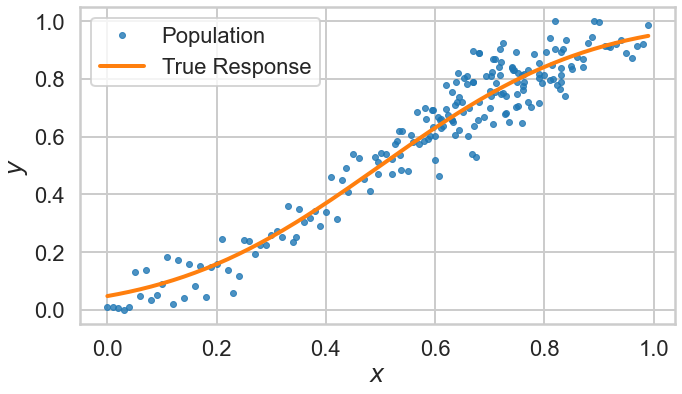

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(x, y, '.', alpha=0.8, label=r'Population')
ax.plot(x, f, lw=4, label='True Response')

ax.legend(loc='upper left')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

It is often the case that you just can't make observations at every single value of $x$.  We will simulate this situation by making a random choice of $60$ points from the full $200$ points.  We do it by choosing the indices randomly and then using these indices as a way of getting the appropriate samples.

In [5]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False)) # Using sort to make plotting easier later
indexes

array([  0,   1,   5,  11,  17,  19,  22,  24,  31,  43,  49,  51,  53,
        55,  56,  58,  61,  64,  65,  70,  73,  76,  77,  80,  82,  89,
        96,  98, 105, 109, 112, 113, 115, 117, 119, 122, 130, 133, 134,
       137, 138, 139, 140, 144, 147, 151, 153, 157, 162, 168, 172, 173,
       179, 183, 185, 188, 189, 192, 194, 199])

Note:  If you are not familiar with the `numpy` `sort` method or the `numpy random.choice()` method, then please take a moment to look them up in the `numpy` documentation.

Moving on, let's get the $60$ random samples from our dataset.

In [6]:
# Create a new dataframe from the random points
sample_df = pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes])) # New dataframe
sample_df.head()

,x,f,y
0,0.00,0.047790,0.011307
1,0.01,0.051199,0.010000
2,0.05,0.066807,0.130963
3,0.11,0.096800,0.183821
4,0.17,0.135666,0.152538


Let's take one more look at our data to see which points we've selected.

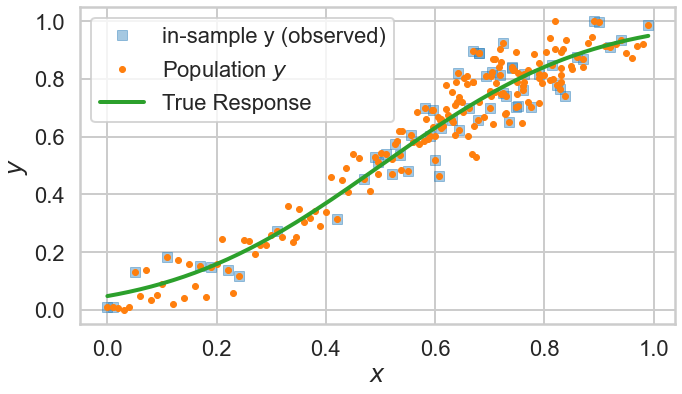

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(sample_df['x'], sample_df['y'], 's', alpha=0.4, ms=10, label="in-sample y (observed)")
ax.plot(x,y, '.', label=r'Population $y$')
ax.plot(x,f, lw=4, label='True Response')

ax.legend(loc='upper left')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

fig.tight_layout()

Now we do our favorite thing and split the sample data into training and testing sets.

Note that here we are actually getting indices instead of the actual training and test set.  This is okay and is another way of generating train-test splits.

In [8]:
from sklearn.model_selection import train_test_split

datasize=sample_df.shape[0]

#split dataset using the index, as we have x, f, and y that we want to split.
itrain, itest = train_test_split(np.arange(60), train_size=0.8)

xtrain = sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values

xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

Great!  At this point we've explored our data a little bit, selected a sample of the dataset, and done a train-test split on the sample dataset.

<hr style='height:2px'>

Let's move on to the data analysis.  We'll begin with ridge regression.  In particular we'll do ridge regression on a single predictor and compare it with simple linear regression.

To start, let's fit the old classic, linear regression.

In [9]:
from sklearn.linear_model import LinearRegression

# fit the model to training data
simp_reg = LinearRegression().fit(xtrain.reshape(-1,1), ytrain)

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]

print("(beta0, beta1) = ({0:8.6f}, {1:8.6f})".format(beta0_sreg, beta1_sreg))

(beta0, beta1) = (0.001062, 1.030617)


## Part 2: Bootstrapping 

Bootstrap sampling is used in a machine learning ensemble algorithm called bootstrap aggregating (also called bagging). It helps in avoiding overfitting and improves the stability of machine learning algorithms. In bagging, a certain number of equally sized subsets of a dataset are extracted with replacement.

But wait! Unlike `statsmodels`, we don't get confidence intervals for the betas. Fortunately, we can bootstrap to build the confidence intervals



\begin{exercise}

1. In the code below, two key steps of bootstrapping are missing. Fill in the code to draw sample indices with replacement and to fit the model to the bootstrap sample. You'll need `numpy`'s `np.random.choice`.  Here's the [function documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) in case you need it.

2. Visualize the results, and use `numpy`'s `np.percentile`: [function documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html).
\end{exercise}





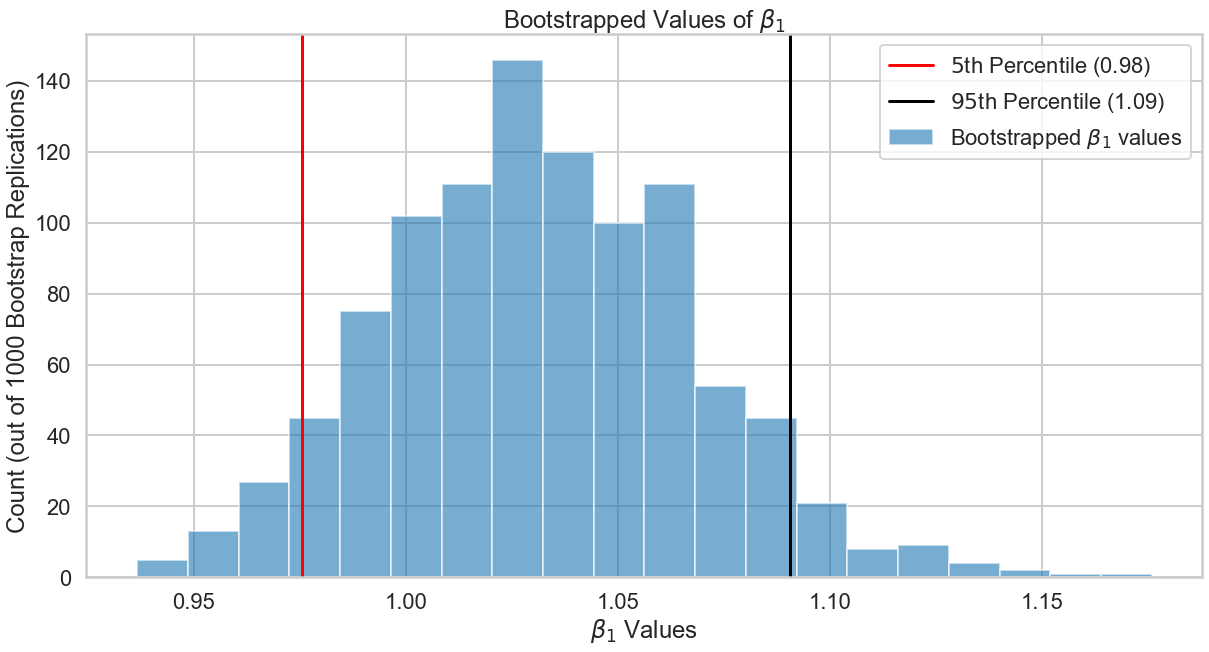

In [10]:
N = 1000
bootstrap_beta1s = np.zeros(N)
for cur_bootstrap_rep in range(N):
    # select indices that are in the resample (easiest way to be sure we grab y values that match the x values)
    inds_to_sample = np.random.choice(xtrain.shape[0], size=xtrain.shape[0], replace=True)
    
    # take the sample
    x_train_resample = xtrain[inds_to_sample]
    y_train_resample = ytrain[inds_to_sample]
    
    # fit the model
    bootstrap_model = LinearRegression().fit(x_train_resample.reshape(-1,1), y_train_resample)
    
    # extract the beta1 and append
    bootstrap_beta1s[cur_bootstrap_rep] = bootstrap_model.coef_[0]

## display the results

# calculate 5th and 95th percentiles
lower_limit, upper_limit = np.percentile(bootstrap_beta1s,[5,95])

# plot histogram and bounds
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.hist(bootstrap_beta1s, 20, alpha=0.6, label=r"Bootstrapped $\beta_{1}$ values")
ax.axvline(lower_limit, color='red', label=r"$5$th Percentile ({:.2f})".format(lower_limit))
ax.axvline(upper_limit, color='black', label=r"$95$th Percentile ({:.2f})".format(upper_limit))

# good plots have labels
ax.set_xlabel(r"$\beta_{1}$ Values")
ax.set_ylabel("Count (out of 1000 Bootstrap Replications)")
plt.title(r"Bootstrapped Values of $\beta_{1}$")
plt.legend();

From the above, we find that the bootstrap $90\%$ confidence interval is well away from $0$. We can confidently say that $\beta_{1}$ is not secretly $0$ and we're being fooled by randomness.

Next we'll dive into ridge regression!

## Part 3: Ridge regression for Simple Linear Regression

To begin, we'll use `sklearn` to do simple linear regression on the sampled training data.  We'll then do ridge regression with the same data, setting the penalty parameter $\lambda$ to zero.  Setting $\lambda = 0$ reduces the ridge problem to the simple ordinary least squares problem, so we expect the results of these models to be identical. 

We will store the regression coefficients in a dataframe for easy comparison.  The cell below provides some code to set up the dataframe ahead of time.  Notice that we don't know the actual values in the `pandas` series, so we just set them to `NaN`.  We will overwrite these later.

In [11]:
regression_coeffs = dict() # Store regression coefficients from each model in a dictionary

regression_coeffs['OLS'] = [np.nan]*2 # Initialize to NaN
regression_coeffs[r'Ridge $\lambda = 0$'] = [np.nan]*2

dfResults = pd.DataFrame(regression_coeffs) # Create dataframe

dfResults.rename({0: r'$\beta_{0}$', 1: r'$\beta_{1}$'}, inplace=True) # Rename rows
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,NaN,NaN
$\beta_{1}$,NaN,NaN


We start with simple linear regression to get the ball rolling.

In [12]:
simp_reg = LinearRegression() # build the the ordinary least squares model

simp_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]

dfResults['OLS'][:] = [beta0_sreg, beta1_sreg]
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,0.001062,NaN
$\beta_{1}$,1.030617,NaN


In [13]:
#y_predict = lambda x : beta0_sreg + beta1_sreg*x # make predictions
ypredict_ols = simp_reg.predict(x.reshape(-1,1))
ypredict_ols.shape

(200,)

We will use the above $\boldsymbol\beta$ coefficients as a benchmark for comparision to the ridge method.  The same coefficients can be obtained with ridge regression, which we demonstrate now.

For reference, here is the ridge regression documentation: [sklearn.linear_model.Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).  

In [14]:
from sklearn.linear_model import Ridge 

The snippet of code below implements the ridge regression with $\lambda = 0$.

**Note:** The weight $\lambda$ is referred to as `alpha` in the documentation.

**Remark:** $\lambda$ goes by many names including, but not limited to: regularization parameter, penalization parameter, shrinking parameter, and weight.  Regardless of these names, it is a hyperparameter.  That is, you set it before you begin the training process.  An algorithm can be very sensitive to its hyperparameters and we will discuss how a method for selecting the "correct" hyperparameter values later in this lab.

In [15]:
ridge_reg = Ridge(alpha = 0) # build the ridge regression model with specified lambda, i.e. alpha

ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_ridge = ridge_reg.intercept_
beta1_ridge = ridge_reg.coef_[0]

ypredict_ridge = ridge_reg.predict(x.reshape(-1,1)) # make predictions everywhere

dfResults[r'Ridge $\lambda = 0$'][:] = [beta0_ridge, beta1_ridge]
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,0.001062,0.001062
$\beta_{1}$,1.030617,1.030617


The beta coefficients for linear and ridge regressions coincide for $\lambda = 0$, as expected. We plot the data and fits.

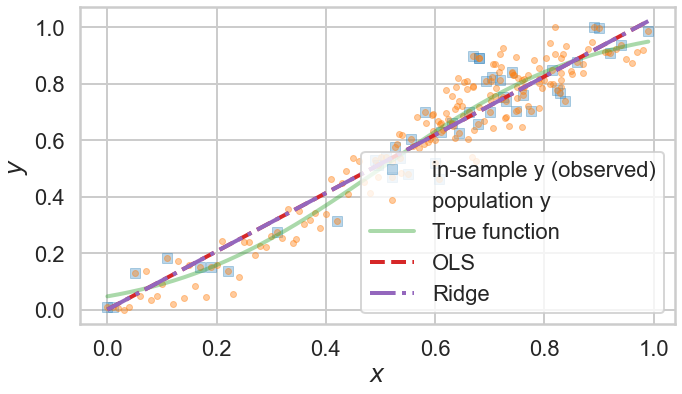

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)") # plot in-sample training data
ax.plot(x, y, '.', alpha=0.4, label="population y") # plot population data
ax.plot(x, f, ls='-',  alpha=0.4, lw=4, label="True function")
ax.plot(x, ypredict_ols, ls='--', lw=4, label="OLS") # plot simple linear regression fit
ax.plot(x, ypredict_ridge, ls='-.', lw = 4, label="Ridge") # plot ridge regression fit

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.legend(loc=4);

fig.tight_layout()

\begin{exercise}
Explore the effect of $\lambda$ on ridge regression.

Make a plot with of the ridge regression predictions with $\lambda = 0, 5, 10, 100$.  Be sure to include a legend.

What happens for very large $\lambda$ (e.g. $\lambda \to \infty$)?

Your plot should look something like the following plot (doesn't have to be exact):
![](ridge_lambda.png)
\end{exercise}



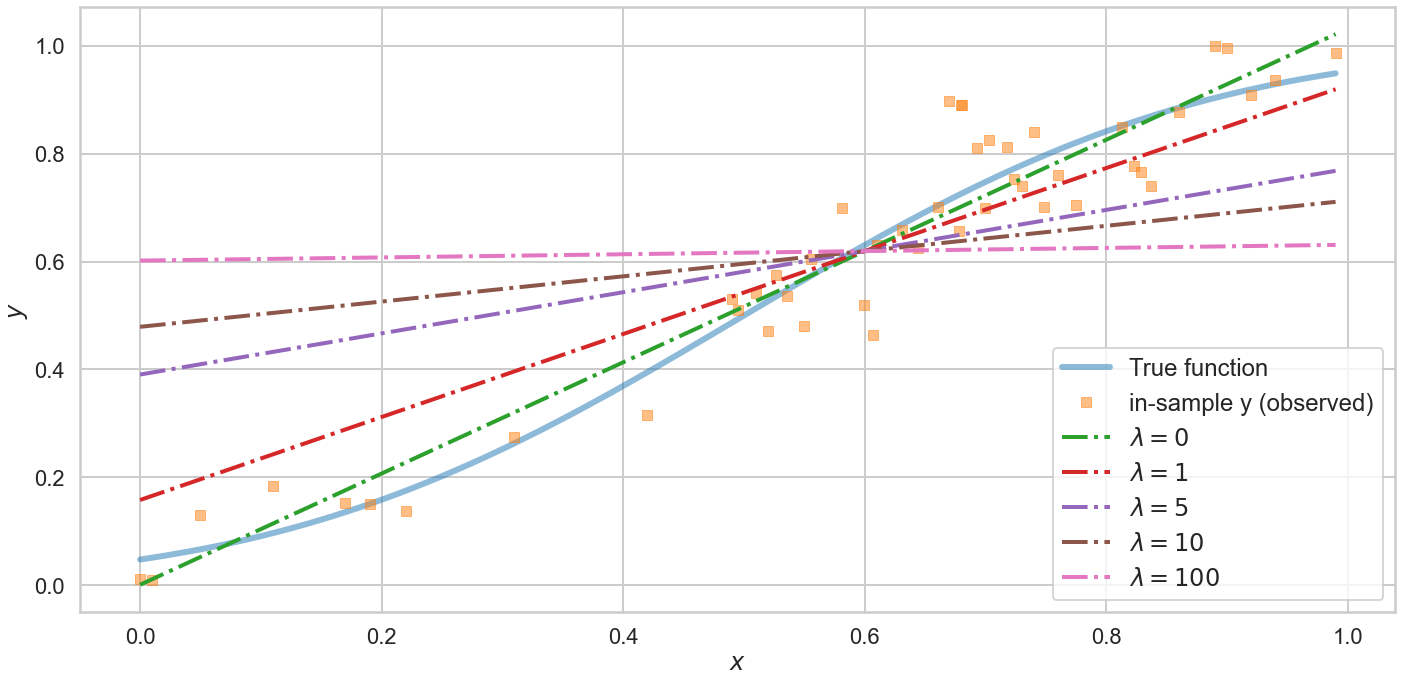

In [17]:
# Your code here
fig, ax = plt.subplots(1,1, figsize=(20,10))

pen_params = [0, 1, 5, 10, 100]

ax.plot(x, f, ls='-', lw=6, alpha=0.5, label="True function")
ax.plot(xtrain, ytrain, 's', alpha=0.5, ms=10, label="in-sample y (observed)") # plot in-sample training data

for alpha in pen_params:
    ridge_reg = Ridge(alpha = alpha) # build the ridge regression model with specified lambda, i.e. alpha
    ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data
    ypredict_ridge = ridge_reg.predict(x.reshape(-1,1))
    ax.plot(x, ypredict_ridge, ls='-.', lw = 4, label=r"$\lambda = {}$".format(alpha)) # plot ridge regression fit

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.legend(loc=4, fontsize=24);

fig.tight_layout()

fig.savefig('ridge_lambda.png')

### Part 3 Recap
That was nice, but we were just doing simple linear regression.  We really want to do more interesting regression problems like multilinear regression.  We will do so in the next section.

## Part 4: Ridge regression with polynomial features on a grid

Now we'll make a more complex model by adding polynomial features.  Instead of building the linear model $y = \beta_0 + \beta_1 x$, we build a polynomial model $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \ldots \beta_d x^d$ for some $d$ to be determined.  This regression will be linear though, since we'll be treating  $x^2, \ldots, x^d$ themselves as predictors in the linear model.

The design matrix $\mathbf{X}$ contains columns corresponding to $1, x, x^2, \ldots, x^d$. To build it, we use `sklearn`. (The particular design matrix is also known as the [*Vandermonde* matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix)).  For example, if we have three observations<br><br>
\begin{align*}
  \left\{\left(x_{1}, y_{1}\right), \left(x_{2}, y_{2}\right), \left(x_{3}, y_{3}\right)\right\}
\end{align*}<br>
and we want polynomial features up to and including degree $4$, the design matrix looks like<br><br>
\begin{align*}
X = \begin{bmatrix}
x_1^0 & x_1^1 & x_1^2 & x_1^3 & x_1^4\\
x_2^0 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
x_3^0 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix} = 
\begin{bmatrix}
1& x_1^1 & x_1^2 & x_1^3 & x_1^4\\
1 & x_2^1 & x_2^2 & x_2^3 & x_2^4\\
1 & x_3^1 & x_3^2 & x_3^3 & x_3^4\\
\end{bmatrix}.
\end{align*}

\begin{exercise}
1. Make a toy vector called `toy`, where  
\begin{align*}
  \mathrm{toy} = 
  \begin{bmatrix}
    0 \\
    2 \\
    5 \\
  \end{bmatrix}. 
\end{align*}
2. Build the feature matrix up to (and including) degree $4$. Confirm that the entries in the matrix are what you'd expect based on the above discussion.

**Note:** You may use `sklearn` to build the matrix using `PolynomialFeatures()`.
\end{exercise}



In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
# your code here
toy = np.array([0, 2, 5])
PolynomialFeatures(4).fit_transform(toy.reshape(-1,1))

array([[  1.,   0.,   0.,   0.,   0.],
       [  1.,   2.,   4.,   8.,  16.],
       [  1.,   5.,  25., 125., 625.]])

We now continue working with our data.  We write a function to make polynomial features of given degrees and we store the features in a dictionary. 

\begin{exercise}
The code provided below is missing a few lines and it's missing many comments.  Do the following:
1. Comment every line of the code
   * Normally, you won't do such excessive commenting.  In this case, we want to make sure you understand every single line since you didn't actually write this code.
2. Fill in the missing lines
   * Create a ridge regression object at each $\lambda$ value in the list
   * Perform the ridge regression using the `fit` method from the newly created ridge regression object
   * Make a prediction on the grid and store the results in `ypredict_ridge`.

\end{exercise}



**Note:** We're not giving you an example figure here since we gave you most of the code.

**Warning!** Make sure you understand the entire code!  There are many nice things in there.

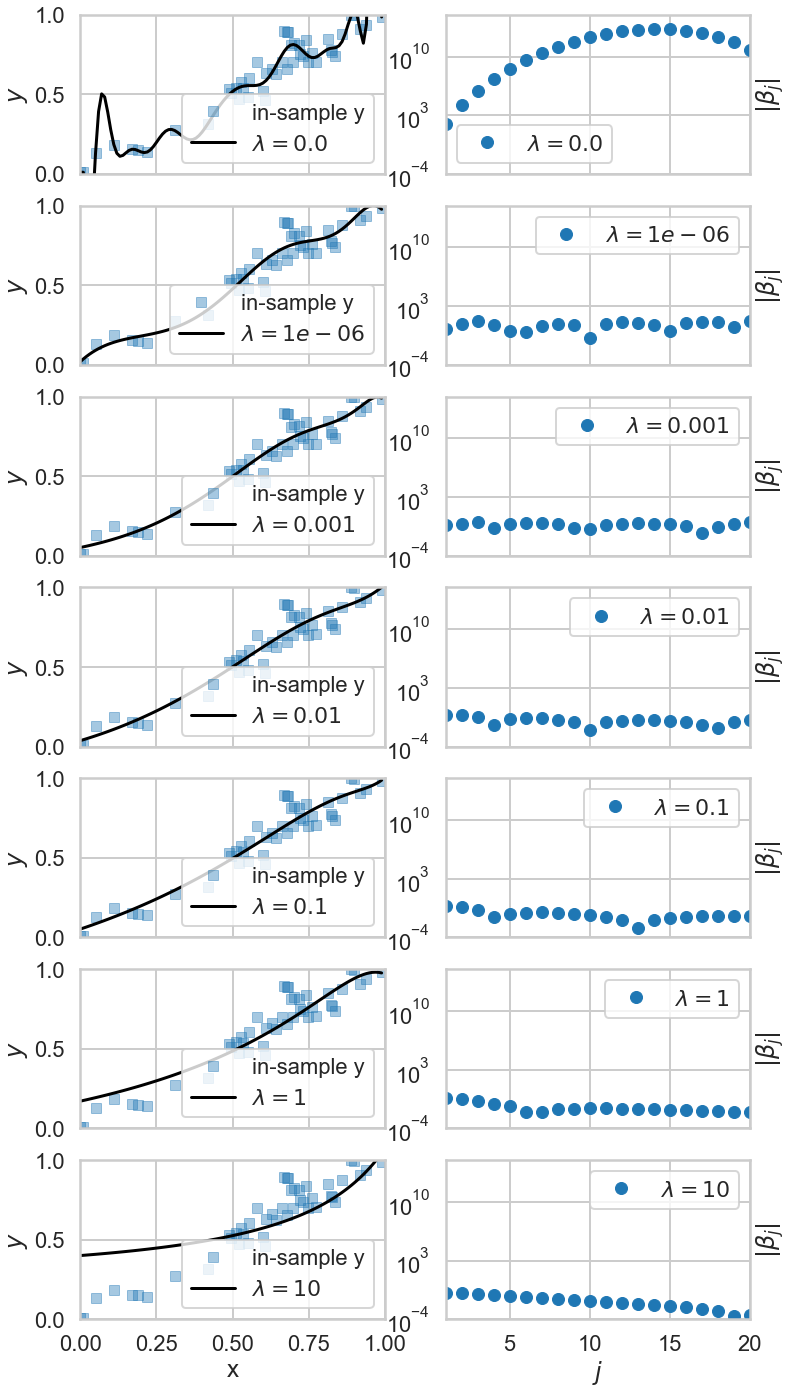

In [20]:
d = 20 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
rows = 7
cols = 2
lambdas = [0., 1e-6, 1e-3, 1e-2, 1e-1, 1, 10] # Various penalization parameters to try
grid_to_predict = np.arange(0, 1, .01) # Predictions will be made on this grid

# Create training set and test set
Xtrain = PolynomialFeatures(d).fit_transform(xtrain.reshape(-1,1))
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))

fig, axs = plt.subplots(rows, cols, sharex='col', figsize=(12, 24)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg = Ridge(alpha = lam) # Create regression object
    ridge_reg.fit(Xtrain, ytrain) # Fit on regression object
    ypredict_ridge = ridge_reg.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i,0].plot(xtrain, ytrain, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i,0].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i,0].set_ylabel('$y$') # y axis label
    axs[i,0].set_ylim((0, 1)) # y axis limits
    axs[i,0].set_xlim((0, 1)) # x axis limits
    axs[i,0].legend(loc='best') # legend
    
    coef = ridge_reg.coef_.ravel() # Unpack the coefficients from the regression
    
    axs[i,1].semilogy(np.abs(coef), ls=' ', marker='o', label=r"$\lambda =  {0}$".format(lam)) # plot coefficients
    axs[i,1].set_ylim((1e-04, 1e+15)) # Set y axis limits
    axs[i,1].set_xlim(1, 20) # Set y axis limits
    axs[i,1].yaxis.set_label_position("right") # Move y-axis label to right
    axs[i,1].set_ylabel(r'$\left|\beta_{j}\right|$') # Label y-axis
    axs[i,1].legend(loc='best') # Legend

# Label x axes
axs[-1, 0].set_xlabel("x")
axs[-1, 1].set_xlabel(r"$j$");

As you can see, as we increase $\lambda$ from 0 to 1, we start out overfitting, then doing well, and then our fits develop a mind of their own irrespective of data, as the penalty term dominates.

\begin{exercise}
What would you expect if you compared a performance metric between these models on a grid?  What performance metric should you use?
\end{exercise}



> **YOUR DISCUSSION HERE** 
    I would expect similiar results of performance between these models and the ones on a grid. I would use all of perfomance metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE),R² and (R-Squared)

### Part 4 Recap
We did a ridge regression on our dataset where the features were polynomial features.  We also assessed the impact of the regularization parameter on the solution.  

## Part 5: Cross-validation --- Finding the best penalization parameter
Let's use cross-validation to determine the critical value of $\lambda$, which we'll refer to as $\lambda^*$. To do this we use the concept of a *meta-estimator* from `scikit-learn`.

Model selection is supported by two distinct meta-estimators:
1. `GridSearchCV`
2. `RandomizedSearchCV`
The input to these meta-estimators is an estimator, which has some hyperparameters (e.g. $\lambda$) that need to be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:
```python
    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier = GridSearchCV(est, param_grid=parameters, cv=4, scoring="neg_mean_squared_error")
```
The `GridSearchCV` replaces the manual iteration over the folds using `KFolds` and the averaging we just did, doing it all for us. It takes a hyperparameter grid in the shape of a dictionary as input, and sets $\lambda$ to the values you want to try, one by one. It then trains the model using cross-validation, and gets the error for each value of the hyperparameter $\lambda$. Finally it compares the errors for the different $\lambda$'s, and picks the best choice model.

Here is a helper function that we will use to get the best Ridge regression.

In [21]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(x: np.ndarray, y: np.ndarray, list_of_lambdas: list, n_folds: int =4):
    est = Ridge()
    parameters = {'alpha': list_of_lambdas}
    # the scoring parameter below is the default one in ridge, but you can use a different one
    # in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(x, y)
    return gs

\begin{exercise}
Use the function above to fit the model on the training set with $4$-fold cross validation.  Save the fit as the variable `fitmodel`.
\end{exercise}



In [22]:
lambs = [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
# your code here
fitmodel = cv_optimize_ridge(Xtrain, ytrain, lambs, n_folds=4)

In [23]:
print(fitmodel.best_estimator_, "\n")
print(fitmodel.best_params_, "\n")
print(fitmodel.best_score_, "\n")

Ridge(alpha=1e-05) 

{'alpha': 1e-05} 

-0.007384839812640294 



We also output the mean cross-validation error at different $\lambda$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

In [24]:
fitmodel.cv_results_

{'mean_fit_time': array([0.00126445, 0.00077528, 0.00025713, 0.00048453, 0.00024784,
        0.00023824, 0.        , 0.00073725, 0.00048381, 0.00048453,
        0.00099689]),
 'std_fit_time': array([3.98870560e-04, 4.48040130e-04, 4.45369910e-04, 4.84987883e-04,
        4.29264740e-04, 4.12643378e-04, 0.00000000e+00, 4.26746159e-04,
        4.83936902e-04, 4.84730606e-04, 1.45391356e-06]),
 'mean_score_time': array([0.00039017, 0.00049663, 0.00051272, 0.        , 0.00049925,
        0.00024492, 0.00050771, 0.00024974, 0.        , 0.00025052,
        0.        ]),
 'std_score_time': array([0.00041968, 0.00049664, 0.00051329, 0.        , 0.00049925,
        0.00042421, 0.00050969, 0.00043257, 0.        , 0.00043391,
        0.        ]),
 'param_alpha': masked_array(data=[1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001,
                    0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
       

In [25]:
fit_lambdas = [d['alpha'] for d in fitmodel.cv_results_['params']]
fit_scores = fitmodel.cv_results_['mean_test_score']

Now we make a `log-log` plot of `-fit_scores` versus `fit_lambdas`.

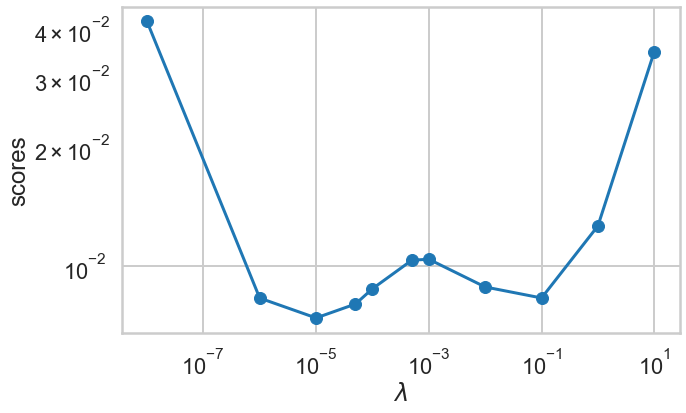

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(fit_lambdas, -fit_scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('scores');

### SK-learn's `cross_val_score`: Easier Cross Validation
`GridSearchCV` is an important tool when you are searching over many hyperparameters (and believe us, you will be), but when you only need to get CV scores for a particular model, some students find `cross_val_score` more intuitive.

In [27]:
from sklearn.model_selection import cross_val_score

lr_object =  Ridge(alpha=0)
cross_val_score(lr_object, Xtrain, ytrain, cv=5)

array([-1.76448090e+04, -1.65056831e+04, -1.44197807e+04, -6.39627360e+03,
       -8.55904241e+06])

We can loop over particular models and get scores for each (equivalent to GridSearchCV over the given parameter settings).

In [28]:
for cur_alpha in [1e-8, 1e-4, 1e-2, 1.0, 10.0]:
    lr_object =  Ridge(alpha=cur_alpha)
    scores = cross_val_score(lr_object, Xtrain, ytrain, cv=5)
    print("lambda {0}\t R^2 scores: {1}\t Mean R^2: {2}".format(cur_alpha,scores,np.mean(scores)))

lambda 1e-08	 R^2 scores: [ 0.91193373  0.90800802  0.97790729  0.88983208 -6.67531219]	 Mean R^2: -0.5975262129780408
lambda 0.0001	 R^2 scores: [0.92179603 0.90317202 0.96120357 0.87694036 0.00918214]	 Mean R^2: 0.7344588225187261
lambda 0.01	 R^2 scores: [0.90595635 0.91506013 0.96186196 0.86586582 0.10472418]	 Mean R^2: 0.7506936877026127
lambda 1.0	 R^2 scores: [0.80711038 0.8563903  0.92375632 0.79562689 0.30944141]	 Mean R^2: 0.7384650586219677
lambda 10.0	 R^2 scores: [ 0.35024977  0.53418179  0.67386397  0.51188586 -0.27610727]	 Mean R^2: 0.3588148239166634


### Built-in Cross Validation: `RidgeCV` and `LassoCV`
Some sklearn models have built-in, automated cross validation to tune their hyper parameters. 

In [29]:
from sklearn.linear_model import RidgeCV

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=5)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )

Best model searched:
alpha = 0.01
intercept = 0.03711440528508836
betas = [ 0.          0.57389895  0.62036665  0.29805322 -0.03337119 -0.22234362
 -0.27694138 -0.24341135 -0.16532679 -0.07427749  0.00982133  0.07606479
  0.11979795  0.14037436  0.13951062  0.12015115  0.08572418  0.03968031
 -0.01477317 -0.07480746 -0.13802357], 


### Important note: 

1. For any tool more automated than literally using k_fold, just setting `cv=5` will **NOT** shuffle your data by default.  This can be a problem with time-series data!
2. To force shuffling, explicitly pass a `KFold` object (with shuffling turned on) to the cv argument
3. You may prefer a strategy where you shuffle the rows of your data at the outset of analysis

In [30]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
from sklearn.model_selection import KFold
splitter = KFold(5, random_state=42, shuffle=True)

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=splitter)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )

Best model searched:
alpha = 0.01
intercept = 0.03711440528508836
betas = [ 0.          0.57389895  0.62036665  0.29805322 -0.03337119 -0.22234362
 -0.27694138 -0.24341135 -0.16532679 -0.07427749  0.00982133  0.07606479
  0.11979795  0.14037436  0.13951062  0.12015115  0.08572418  0.03968031
 -0.01477317 -0.07480746 -0.13802357], 


## Part 5b: Refitting on full training set
At this point, we have determined the best penalization parameter for the ridge regression on our current dataset using cross validation.  Let's refit the estimator on the training set and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.

\begin{exercise}
Assign to variable `est` the classifier obtained by fitting the entire training set using the best $\lambda$ found above.  Assign the predictions to the variable `ypredict_ridge_best`.
\end{exercise}



In [31]:
# your code here
best_lambda = fitmodel.best_params_['alpha']
est = Ridge(alpha=best_lambda).fit(Xtrain,ytrain)
ypredict_ridge_best = est.predict(test_set)
est.coef_

array([ 0.        ,  1.40758083, -4.97743774,  8.41928311,  2.01671558,
       -2.79310956, -4.31587219, -3.70213724, -1.90204309,  0.2878219 ,
        2.18520764,  3.31290961,  3.46477265,  2.70043267,  1.28723416,
       -0.37919713, -1.85193963, -2.69467514, -2.52444812, -1.03633872,
        1.98653241])

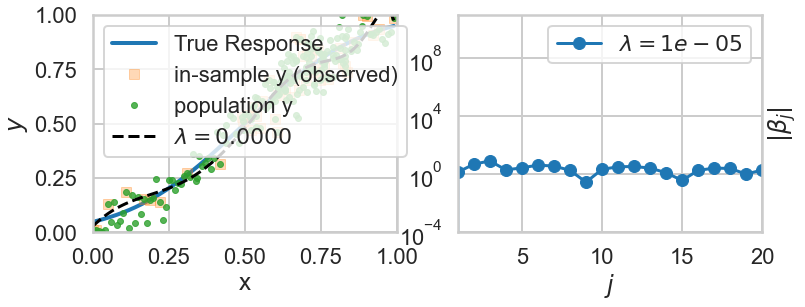

In [32]:
# code provided from here on
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
left = 0
right = 1

axs[left].plot(x,f, lw=4, label='True Response')
axs[left].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
axs[left].plot(x, y, '.', alpha=0.8, label="population y")
axs[left].plot(grid_to_predict, ypredict_ridge_best, 'k--', label=r"$\lambda =  {{{0:1.4f}}}$".format(best_lambda))
axs[left].set_ylabel('$y$')
axs[left].set_ylim((0, 1))
axs[left].set_xlim((0, 1))
axs[left].legend(loc=2)
coef = est.coef_.ravel()
axs[right].semilogy(np.abs(coef), marker='o', label=r"$\lambda =  {0}$".format(best_lambda))
axs[right].set_ylim((1e-04, 1.0e+11))
axs[right].set_xlim(1, 20)
axs[right].yaxis.set_label_position("right")
axs[right].set_ylabel(r'$\left|\beta_{j}\right|$')
axs[right].legend(loc='best')
axs[left].set_xlabel("x")
axs[right].set_xlabel(r'$j$');

In [33]:
#One more nice plot:
from sklearn.linear_model import Lasso 

ridge_coef = []
lasso_coef = []
for lamb in lambs:
    ridge_coef.append(Ridge(alpha=lamb).fit(Xtrain,ytrain).coef_)
    lasso_coef.append(Lasso(alpha=lamb).fit(Xtrain,ytrain).coef_)
ridge_coef[0:2]

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1356237646275835, tolerance: 0.00034239984151136933
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12824747318539542, tolerance: 0.00034239984151136933
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06289963674179022, tolerance: 0.00034239984151136933
  model = cd_fast.enet_coordinate_descent(


[array([   0.        ,    4.89569829,  -49.73064045,  206.0072751 ,
        -303.99023666,  -22.80133419,  259.9670587 ,  173.69303921,
         -84.3475196 , -251.1017716 , -224.79006397,  -55.62743286,
         140.74588745,  259.59008247,  247.80195953,  113.00935721,
         -86.72817949, -261.36386077, -307.92340668, -126.22408873,
         370.15302563]),
 array([  0.        ,   1.76142078,  -7.57552313,  15.0808419 ,
         -5.36907998,  -1.02853375,   0.84332749,  -3.71022126,
         -7.34602366,  -5.75783015,   0.16443213,   6.93044582,
         11.13161744,  10.89862166,   6.25105771,  -1.20676128,
         -8.8510536 , -13.61875301, -12.48194877,  -2.77796748,
         17.59861824])]

Text(0.5, 1.0, 'Lasso polynomial coefficients as a function of lambda')

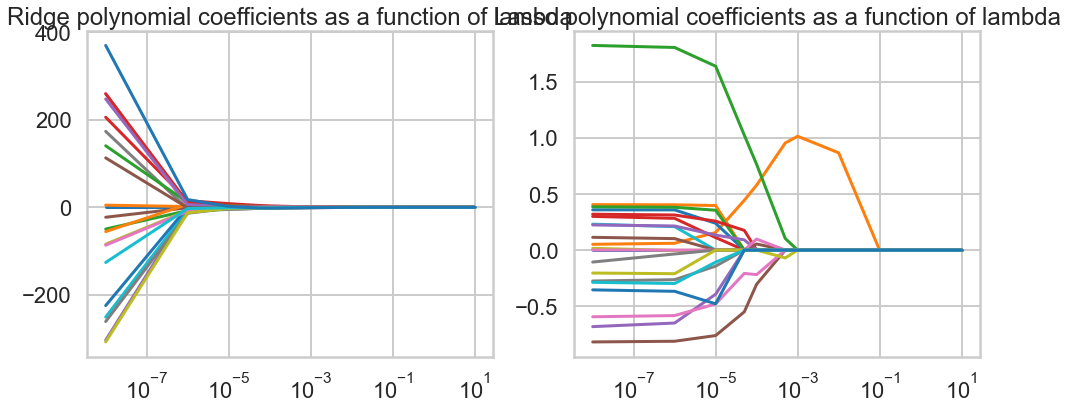

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
left = 0
right = 1
axs[left].plot(lambs,ridge_coef)
axs[left].set_xscale("log")
axs[left].set_title("Ridge polynomial coefficients as a function of lambda")
#axs[left].legend(loc='best')
axs[right].plot(lambs,lasso_coef)
axs[right].set_xscale("log")
axs[right].set_title("Lasso polynomial coefficients as a function of lambda")